In [1]:
#%matplotlib notebook

import itertools
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns

from matplotlib.colors import ListedColormap

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from yellowbrick.features import ParallelCoordinates
from yellowbrick.features import Rank1D
from yellowbrick.features import Rank2D
from yellowbrick.features.importances import FeatureImportances

In [2]:
MATH_CSV = "../student-alcohol-consumption/student-mat.csv"
PORT_CSV = "../student-alcohol-consumption/student-por.csv"

categorical_features = [
    'school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 
    'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 
    'nursery', 'higher', 'internet', 'romantic'
]
numerical_features = [
    'age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
    'famrel', 'freetime', 'goout', 'health', 'absences', 'G1', 'G2', 
    'G3'
]
unique_feature_identifiers = [
    "school","sex","age","address","famsize","Pstatus","Medu","Fedu",
    "Mjob","Fjob","reason","nursery","internet"
]

math_df = pd.read_csv(MATH_CSV)
port_df = pd.read_csv(PORT_CSV)
result = pd.concat([math_df, port_df])

students_df = result.drop_duplicates(subset=unique_feature_identifiers)
features = categorical_features + numerical_features

<Figure size 432x288 with 0 Axes>

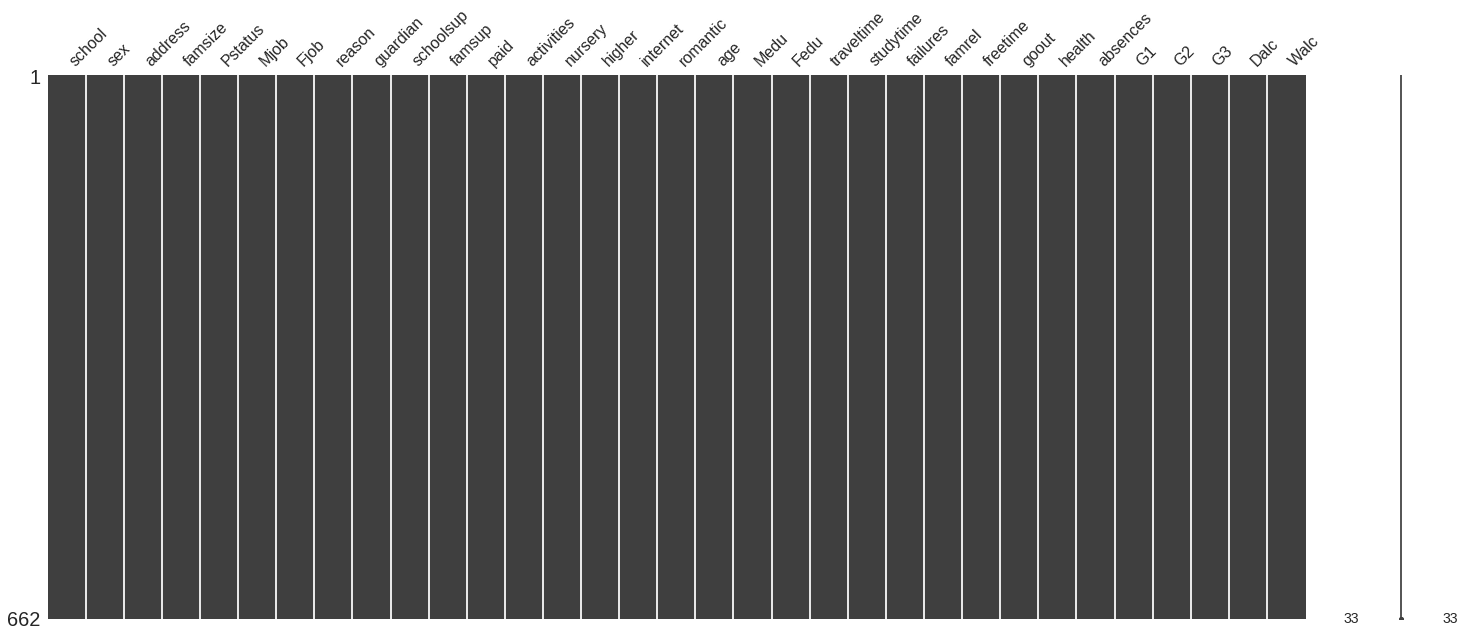

In [3]:
plt.figure()

X = students_df[features + ['Dalc','Walc']]
msno.matrix(X)

plt.show()

In [4]:
selected_features = ['Dalc', 'Walc'] + numerical_features
X = students_df[['Dalc', 'Walc'] + numerical_features]

/home/iancu/anaconda3/envs/ml_env/lib/python3.7/site-packages/yellowbrick/features/rankd.py:262: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = X.as_matrix()


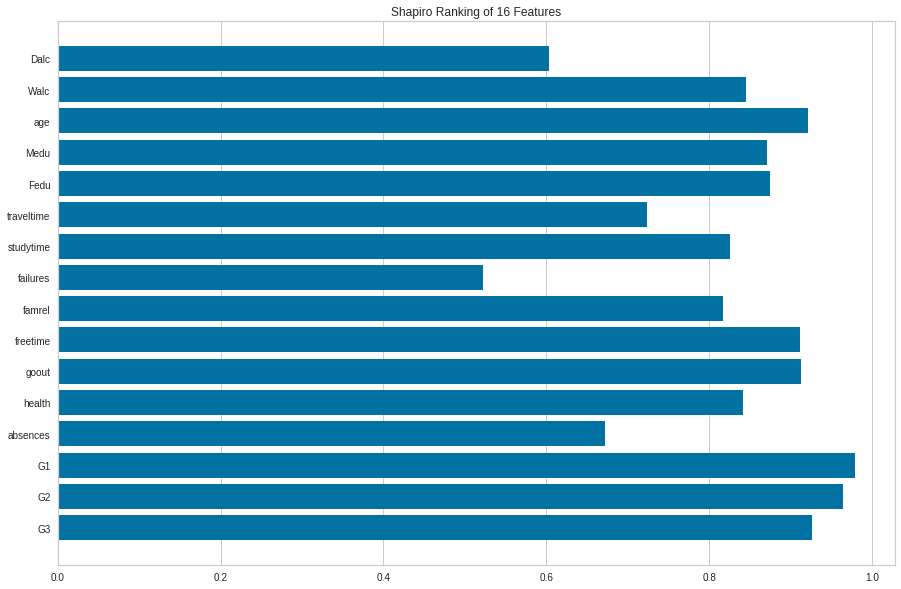

In [5]:
plt.figure(figsize=(15,10))
visualizer = Rank1D(features=selected_features, algorithm='shapiro')

visualizer.fit_transform(X, None)
visualizer.poof()

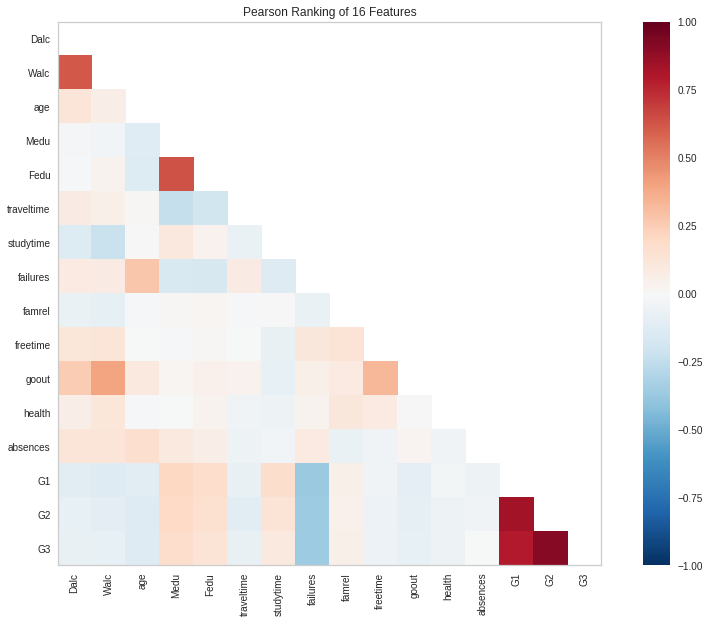

In [6]:
plt.figure(figsize=(15,10))
visualizer = Rank2D(features=selected_features, algorithm='pearson')

visualizer.fit_transform(X, None)
visualizer.poof()

In [7]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def get_correlation_for_categorical_features(df, cols):
    corrM = np.zeros((len(cols),len(cols)))

    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = cramers_v(df[col1], df[col2])
        corrM[idx2, idx1] = corrM[idx1, idx2]
    return corrM

selected_features = ['Dalc', 'Walc'] + categorical_features
corrMatrix = get_correlation_for_categorical_features(students_df, selected_features)
corr = pd.DataFrame(corrMatrix, index=selected_features, columns=selected_features)

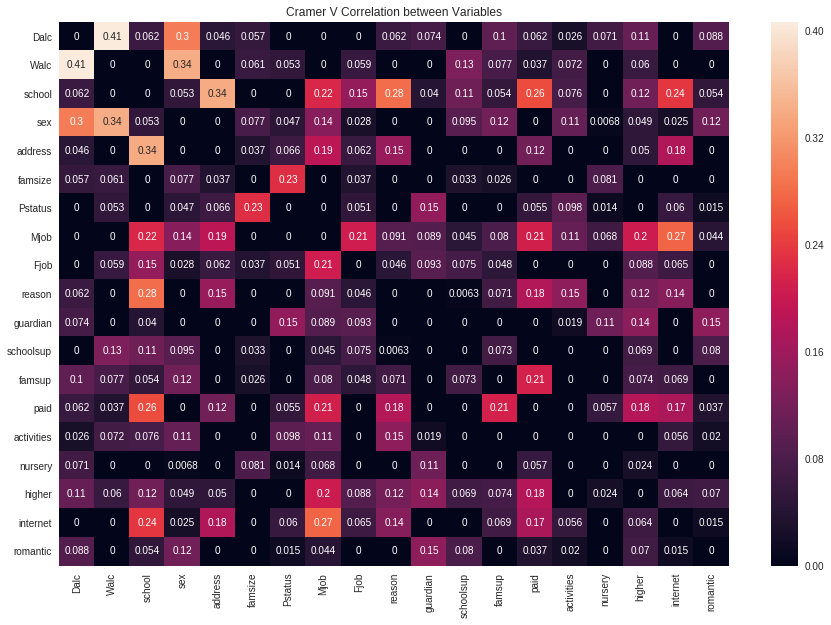

In [8]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = sns.heatmap(corr, annot=True, ax=ax) 
ax.set_title("Cramer V Correlation between Variables")

plt.show()

In [9]:
X = students_df[numerical_features]
classes = ['1', '2', '3', '4', '5']

/home/iancu/anaconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/iancu/anaconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


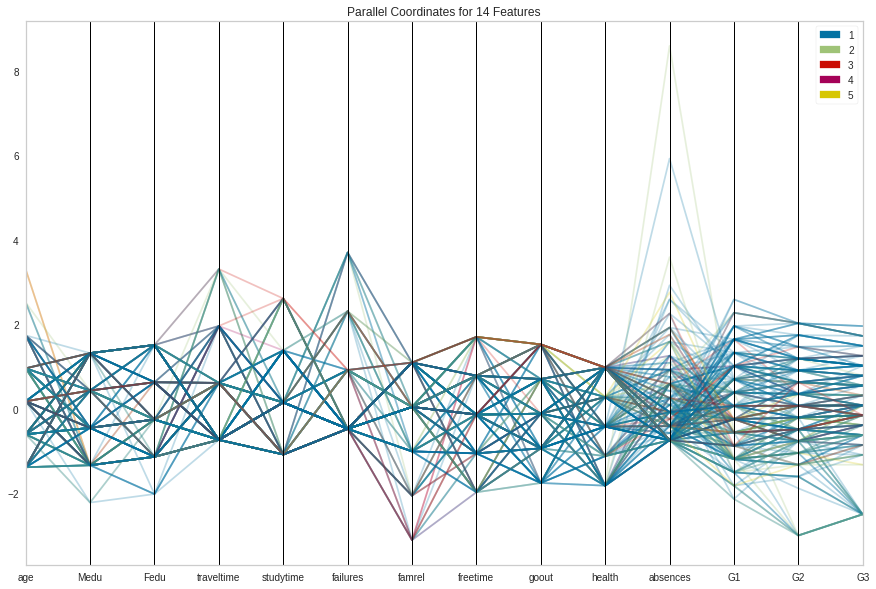

In [10]:
plt.figure(figsize=(15,10))

y = students_df['Dalc'].apply(lambda x: str(x))
visualizer = ParallelCoordinates(
    classes=classes, features=numerical_features, 
    normalize='standard', sample=0.5, shuffle=True
)

visualizer.fit_transform(X, y)
visualizer.poof()

/home/iancu/anaconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/iancu/anaconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


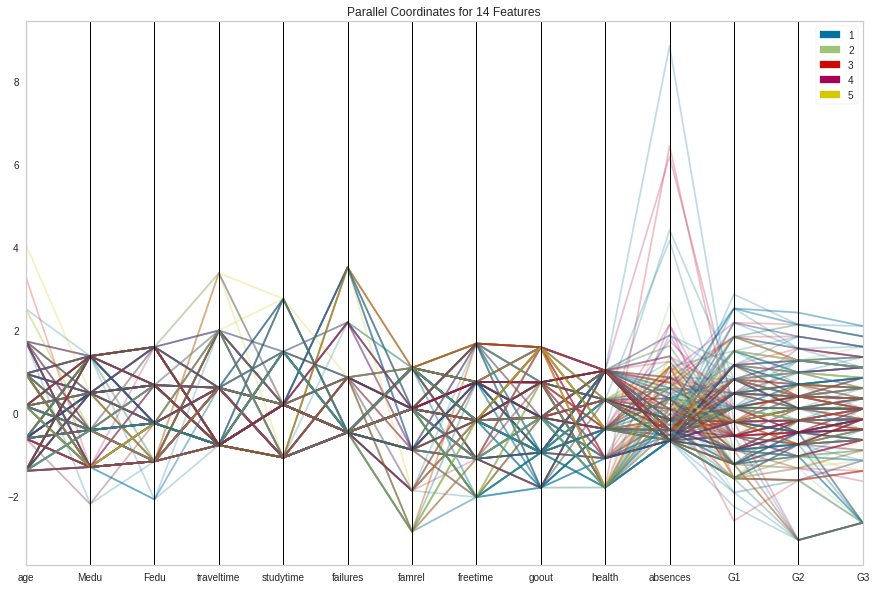

In [11]:
plt.figure(figsize=(15,10))

y = students_df['Walc'].apply(lambda x: str(x))
visualizer = ParallelCoordinates(
    classes=classes, features=numerical_features, 
    normalize='standard', sample=0.5, shuffle=True
)

visualizer.fit_transform(X, y)
visualizer.poof()

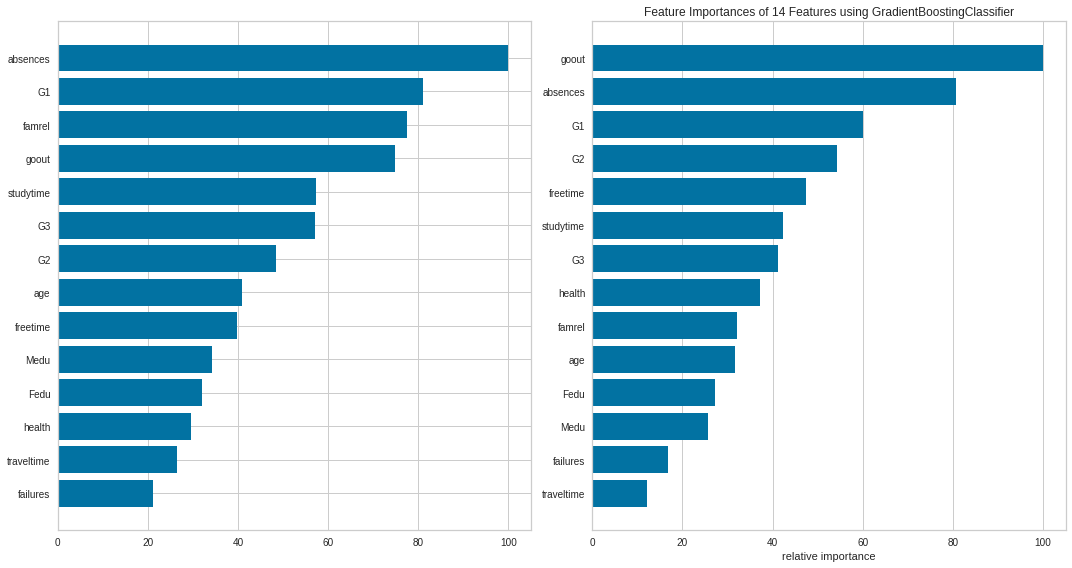

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15,8), squeeze=False)

y = students_df['Dalc']
viz = FeatureImportances(GradientBoostingClassifier(), ax=axes[0][0])
viz.fit(X, y)

y = students_df['Walc']
viz = FeatureImportances(GradientBoostingClassifier(), ax=axes[0][1])
viz.fit(X, y)

viz.poof()

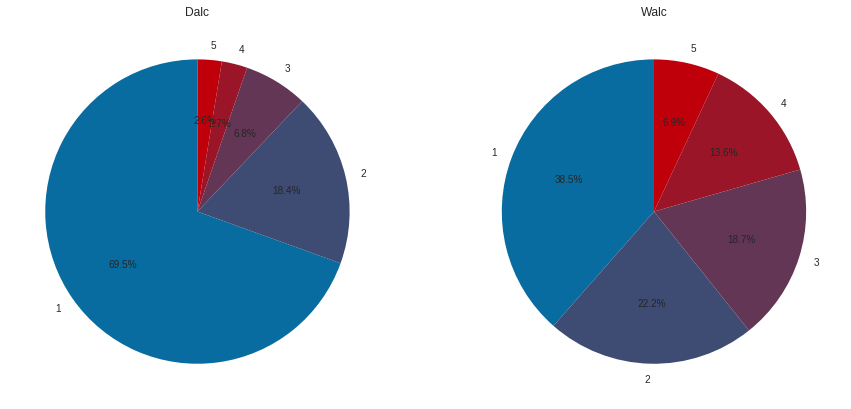

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15,15), squeeze=False)

pie_labels = ['1', '2', '3', '4', '5']
pie_colors = ['#086CA0', '#3E4B73', '#633655', '#9A1528','#BF000B']

axes[0][0].pie(students_df['Dalc'].value_counts().tolist(), 
        labels=pie_labels, colors = pie_colors, autopct='%1.1f%%', startangle=90)
axes[0][1].pie(students_df['Walc'].value_counts().tolist(), 
        labels=pie_labels, colors = pie_colors, autopct='%1.1f%%', startangle=90)

axes[0][0].set_title("Dalc")
axes[0][1].set_title("Walc")

plt.show()

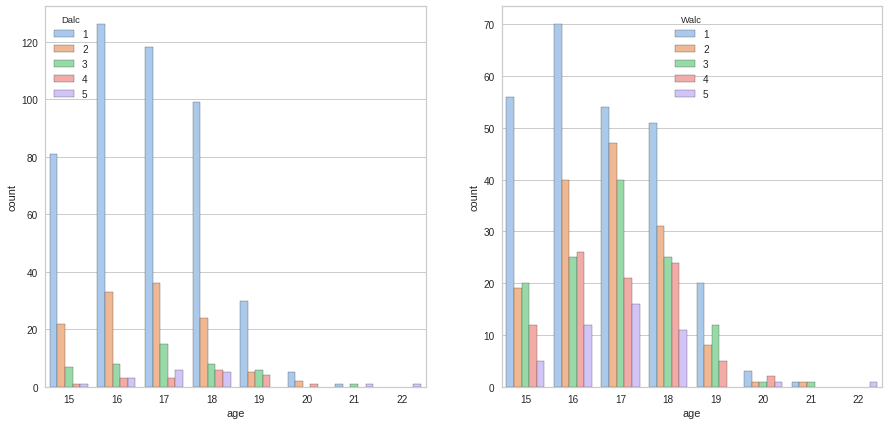

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15,7), squeeze=False)

sns.catplot(x="age", hue="Dalc", kind="count", 
            palette="pastel", edgecolor=".2", 
            data=students_df, ax = axes[0][0])
sns.catplot(x="age", hue="Walc", kind="count", 
            palette="pastel", edgecolor=".2",
            data=students_df, ax = axes[0][1])

plt.close(2)
plt.close(3)
plt.show()

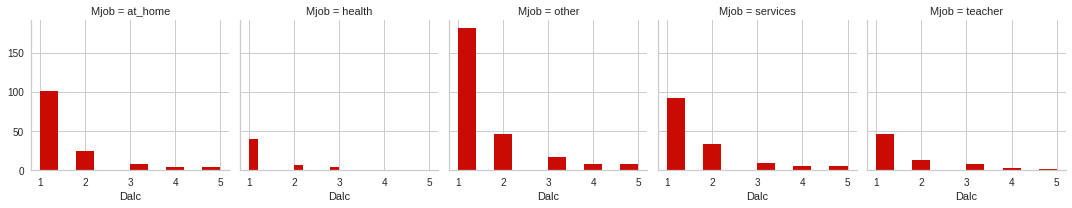

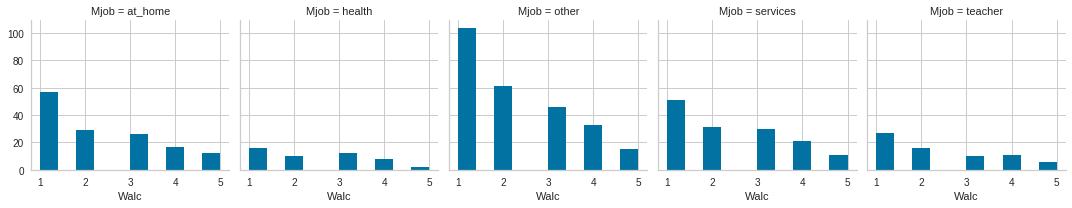

In [15]:
g = sns.FacetGrid(students_df, col="Mjob", height=3, aspect=1)
g = g.map(plt.hist, "Dalc", color=["r"])

g = sns.FacetGrid(students_df, col="Mjob", height=3, aspect=1)
g = g.map(plt.hist, "Walc", color=["b"])

plt.show()

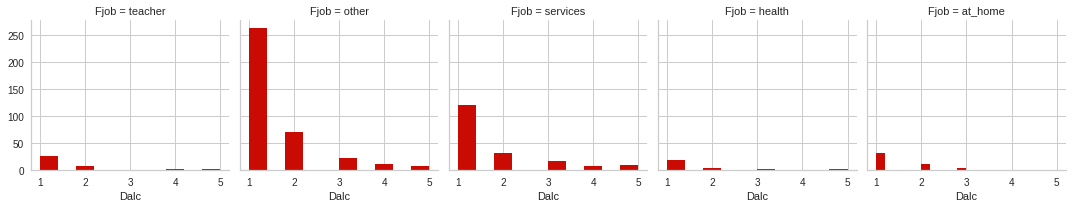

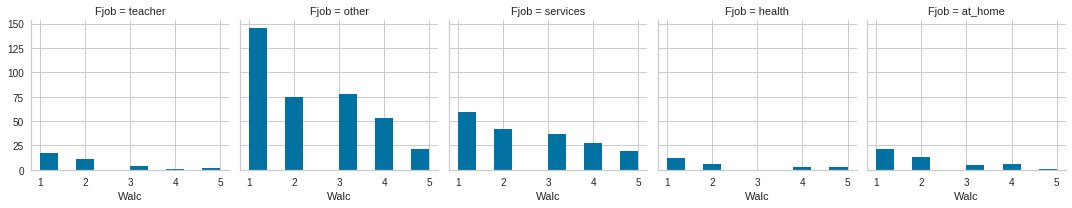

In [16]:
g = sns.FacetGrid(students_df, col="Fjob", height=3, aspect=1)
g = g.map(plt.hist, "Dalc", color=["r"])

g = sns.FacetGrid(students_df, col="Fjob", height=3, aspect=1)
g = g.map(plt.hist, "Walc", color=["b"])

plt.show()

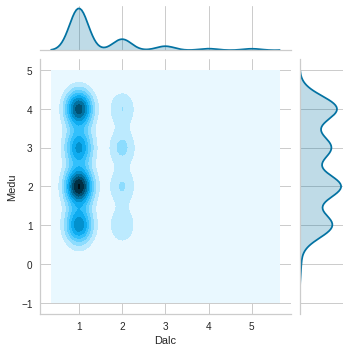

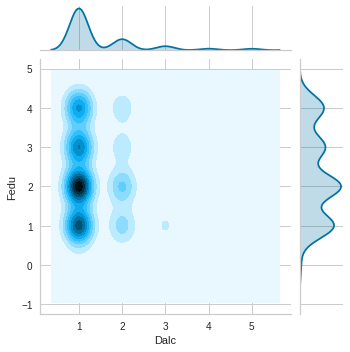

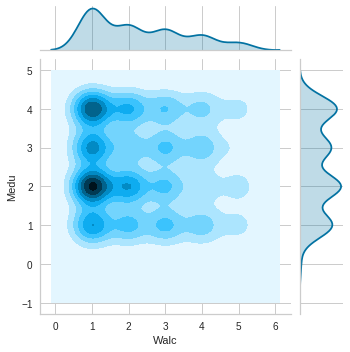

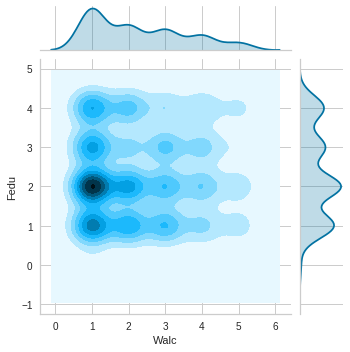

In [17]:
sns.jointplot(x="Dalc", y="Medu", kind="kde",data=students_df, height=5)
sns.jointplot(x="Dalc", y="Fedu", kind="kde",data=students_df, height=5)
sns.jointplot(x="Walc", y="Medu", kind="kde",data=students_df, height=5)
sns.jointplot(x="Walc", y="Fedu", kind="kde",data=students_df, height=5)

plt.show()

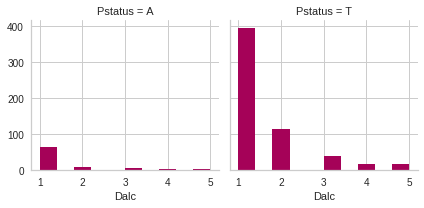

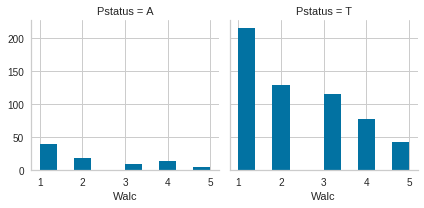

In [18]:
g = sns.FacetGrid(students_df, col="Pstatus")
g = g.map(plt.hist, "Dalc", color="m")
g = sns.FacetGrid(students_df, col="Pstatus")
g = g.map(plt.hist, "Walc", color="b")

plt.show()

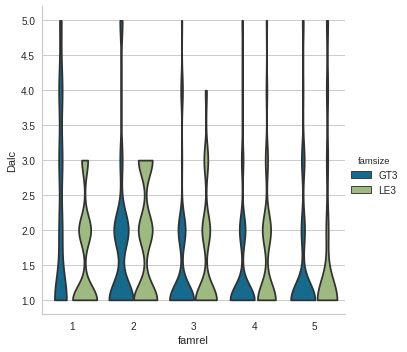

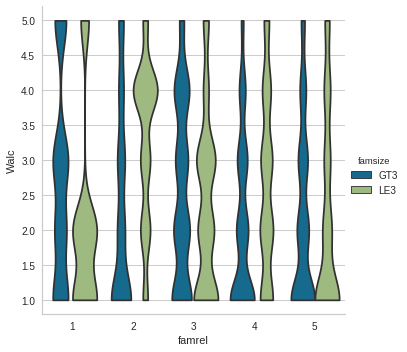

In [19]:
sns.catplot(x="famrel", y="Dalc", hue="famsize",
            kind="violin", bw=.25, cut=0,
            data=students_df, inner=None)
sns.catplot(x="famrel", y="Walc", hue="famsize",
            kind="violin", bw=.25, cut=0,
            data=students_df, inner=None)

plt.show()

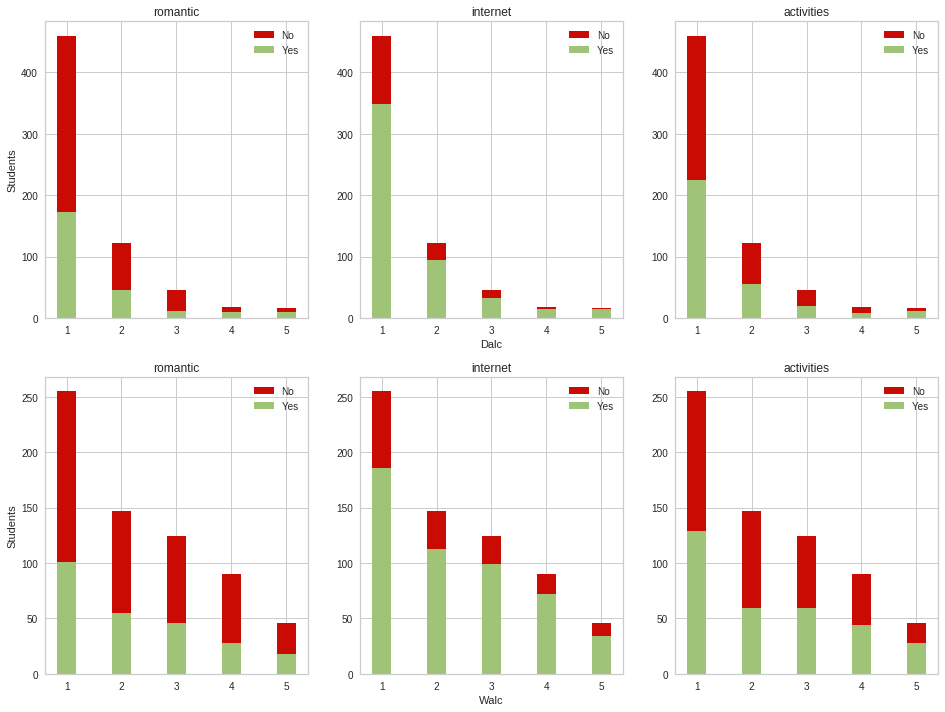

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(16,12), squeeze=False)

ind = np.arange(5)
selected_features = ['romantic', 'internet', 'activities']
students_group = ['Dalc', 'Walc']

for i in range(0,2):      
    for j in range(0,3):
        plot = students_df.groupby([students_group[i], selected_features[j]])\
                        .size()\
                        .reset_index()\
                        .pivot(columns=students_group[i], index=selected_features[j], values=0)
                    
        plt.sca(axes[i][j])
        p1 = plt.bar(ind, plot.loc['yes'], 0.35, color = 'g')
        p2 = plt.bar(ind, plot.loc['no'], 0.35, bottom=plot.loc['yes'], color = 'r')
        plt.xticks(ind, ('1', '2', '3', '4', '5'))
        plt.legend((p2[0], p1[0]), ('No', 'Yes'))
        plt.title(selected_features[j])
        
        if j == 0:
            plt.ylabel('Students')
        
        if j == 1:
            plt.xlabel(students_group[i])

plt.show()

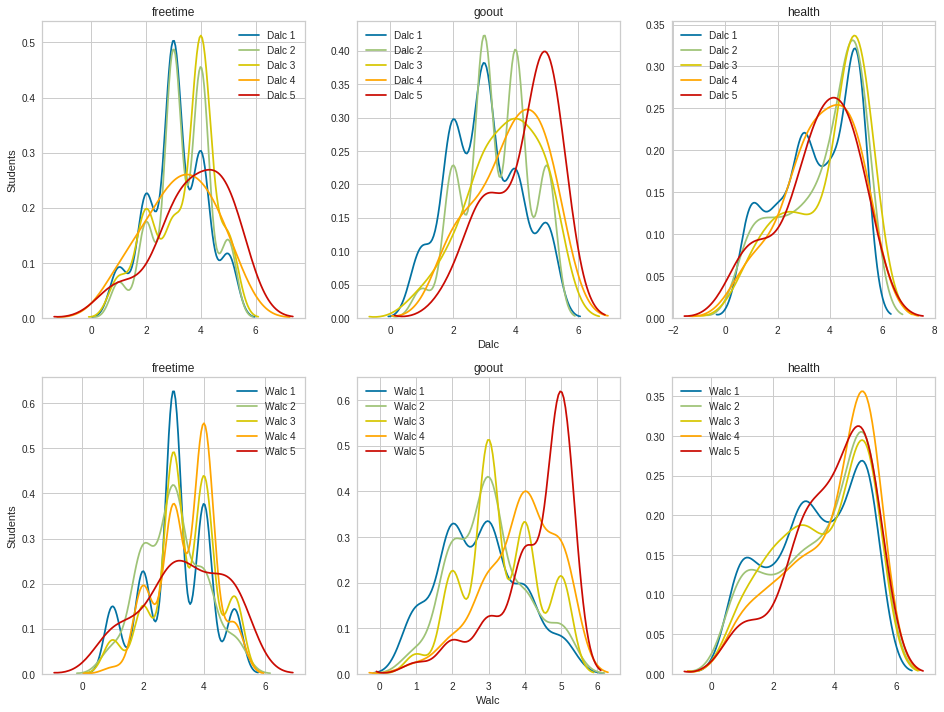

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(16,12), squeeze=False)

selected_features = ['freetime', 'goout', 'health']
students_group = ['Dalc', 'Walc']
colors = ['b', 'g', 'y', 'orange', 'r']
legends = [
    ['Dalc 1','Dalc 2','Dalc 3','Dalc 4','Dalc 5'],
    ['Walc 1','Walc 2','Walc 3','Walc 4','Walc 5']]

for i in range(0,2):
    for j in range(0,3):
        plt.sca(axes[i][j])
        for k in range(1,6):
            sns.kdeplot(students_df[students_df[students_group[i]] == k][selected_features[j]], color=colors[k-1])
        axes[i][j].legend(legends[i])
        plt.title(selected_features[j])
        
        if j == 0:
            plt.ylabel('Students')
        
        if j == 1:
            plt.xlabel(students_group[i])
        
plt.show()

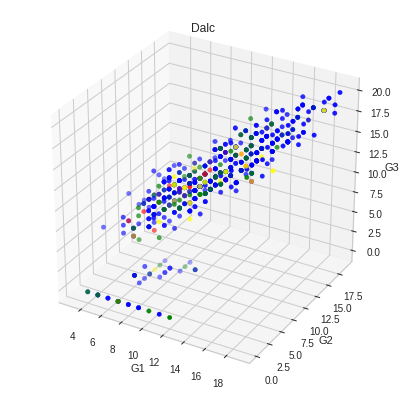

In [22]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

colors = ['blue', 'green', 'yellow', 'orange','red']
ax.scatter(students_df['G1'], students_df['G2'], students_df['G3'],
           c=students_df['Dalc'], cmap=ListedColormap(colors))

ax.set_xlabel('G1')
ax.set_ylabel('G2')
ax.set_zlabel('G3')

ax.set_title("Dalc")

plt.show()

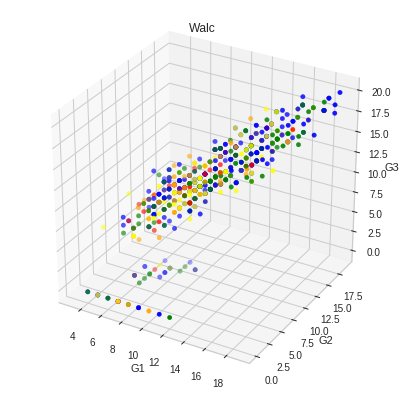

In [23]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

colors = ['blue', 'green', 'yellow', 'orange','red']
ax.scatter(students_df['G1'], students_df['G2'], students_df['G3'],
           c=students_df['Walc'], cmap=ListedColormap(colors))

ax.set_xlabel('G1')
ax.set_ylabel('G2')
ax.set_zlabel('G3')

ax.set_title("Walc")

plt.show()